This notebook is mainly for messing around with Geopandas objects and figuring out what the best way is to plan a path\
To run this code, you need to install shapely, geopandas matplotlib and numpy 

In [1]:
import json
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from shapely.geometry import LineString,MultiLineString
import geopandas as gpd
import numpy as np

In [232]:
# This cell opens the json file that contains field geometry
with open("./data/field_geometry/test_2.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)

In [233]:
# This cell parses the json data and obtains a list with the coordinates for each polygon like
# [[polygon1_coords],[polygon2_coords],....]
# where polygon1_coords looks something like this: [[x1,y1],[x2,y2],......]
coordinates = []
for i in range(len(json_data['features'])):
    coordinates.append(json_data['features'][i]['geometry']['coordinates'])

In [234]:
coordinates[0][0]

[[358.37, 546.33],
 [595.18, 502.9],
 [580, 100],
 [529.97, 22.56],
 [513.55, 18.56],
 [294.72, 51.94],
 [281.7, 62.66],
 [358.37, 546.33]]

<Axes: >

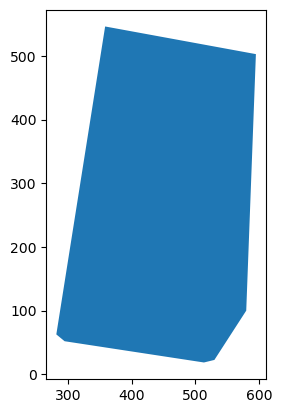

In [235]:
# Here we create a geoseries object from the polygons 
polygon1 = gpd.GeoSeries(Polygon(coordinates[0][0]))
# hole = gpd.GeoSeries(Polygon(coordinates[2][0]))
# Creating a buffer with a specific size (in this case 1)
# obstacle_buffer = hole.buffer(1)
polygon1_buffer = polygon1.buffer(-10)
# hole.plot()
polygon1.plot()

In [6]:
# Here we substract the hole from the field, the first line does this for the field and hole without headlands, the second line does it
# for field and hole with headlands

# Uncomment these lines if you want to have a hole in your field
# field = polygon1.symmetric_difference(hole) 
# field_with_headlands = polygon1_buffer.symmetric_difference(obstacle_buffer)


field = polygon1
field_with_headlands = polygon1_buffer

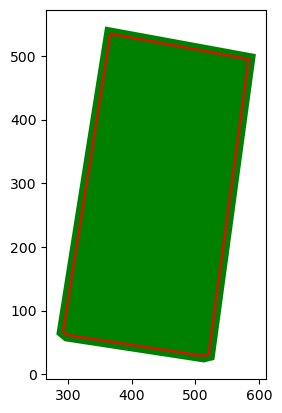

In [7]:
# Plotting the field (green) and headland boundaries
fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
plt.show()

In [8]:
# An easy way to obtain x and y coordinates for a polygon or polyline
polygon1.get_coordinates()

,x,y
0,358.37,546.33
0,595.18,502.90
0,529.97,22.56
0,513.55,18.56
0,294.72,51.94
0,281.70,62.66
0,358.37,546.33


C:\Users\hidde\AppData\Local\Temp\ipykernel_26028\1918966130.py:15: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  swath_clipped.plot(ax = ax, color = 'magenta')


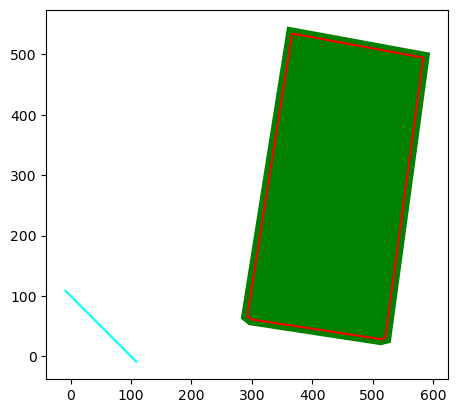

In [9]:
# Creating straight lines as vectors and clipping them to the field boundaries
vector = [[-10,110],[110,-10]]
# Here we make another geoseries object from the vector
swath = gpd.GeoSeries(LineString(vector))
# and we clip the vector so that it only covers the field and does not cross over into the headlands
swath_clipped = gpd.clip(swath,field_with_headlands)


# Plotting the original swath (cyan) and the clipped one (magenta)

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
swath.plot(ax = ax,color = 'cyan', marker = '+')
swath_clipped.plot(ax = ax, color = 'magenta')
plt.show()

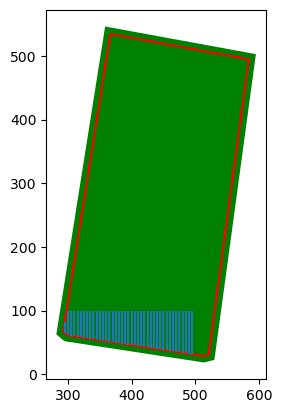

2162.9168561483148


In [10]:

# This cell combines the above cells and creates a bunch of parallel vectors with a fixed distance, clips them to the 
# boundaries of the field and then calculates the total length of the path

vector = []
for i in range(100):
    vector.append([[0+i*5,100],[0+i*5,0]])

swaths = []
swaths_clipped = []
for i in range(len(vector)):
    swaths.append(gpd.GeoSeries(LineString(vector[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax)
        total_swath_length+=swaths_clipped[i][0].length

plt.show()
print(total_swath_length)

In [11]:
# import numpy as np

def rotate_vector_z(vector, theta_z):
    # Convert angle to radians
    theta_z = np.radians(theta_z)

    # 2D Rotation matrix around the z-axis
    R_z = np.array([[np.cos(theta_z), -np.sin(theta_z)],
                    [np.sin(theta_z), np.cos(theta_z)]])

    # Rotate the vector
    rotated_vector = np.dot(R_z, vector)

    return rotated_vector

# Example usage
vector = np.array([1, 0])  # Example vector along the x-axis
theta_z = 45  # Rotation angle in degrees around z-axis

rotated_vector = rotate_vector_z(vector, theta_z)
print("Original Vector:", vector)
print("Rotated Vector around Z-axis:",rotated_vector)

Original Vector: [1 0]
Rotated Vector around Z-axis: [0.70710678 0.70710678]


In [12]:
# Example usage
vector = np.array([10000, 0])  # Example vector along the x-axis
for theta_z in range(0,95,5):
    # theta_z = 45  # Rotation angle in degrees around z-axis
    d = 10
    dx = d/(np.sin(np.radians(theta_z))+0.01)
    rotated_vector = rotate_vector_z(vector, theta_z)
    rotated_vector = [[0,0],list(rotated_vector)]
    vector_list = []
    if theta_z == 0:
        for i in range(-10,10):
            vector_list.append([[rotated_vector[0][0],rotated_vector[0][1]+i*d],[rotated_vector[1][0],rotated_vector[1][1]+i*d]])
    else:
        for i in range(-10,10):
            vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])



    swaths = []
    swaths_clipped = []
    for i in range(len(vector_list)):
        swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
        swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

    # fig, ax = plt.subplots()
    # field.plot(ax = ax, color = 'green')
    # field_with_headlands.boundary.plot(ax = ax,color = 'red')
    total_swath_length = 0
    for i in range(len(swaths_clipped)):
        if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
            # swaths_clipped[i].plot(ax = ax)
            total_swath_length+=swaths_clipped[i][0].length

    # plt.show()
    
    print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))



Theta: 0.000000, total_length: 1162.250173
Theta: 5.000000, total_length: 2231.666540
Theta: 10.000000, total_length: 3212.082166
Theta: 15.000000, total_length: 4182.209563
Theta: 20.000000, total_length: 4878.830359
Theta: 25.000000, total_length: 5378.062301
Theta: 30.000000, total_length: 5781.004133
Theta: 35.000000, total_length: 6093.998788
Theta: 40.000000, total_length: 5760.347749
Theta: 45.000000, total_length: 4611.722952
Theta: 50.000000, total_length: 2772.733779
Theta: 55.000000, total_length: 1274.095000
Theta: 60.000000, total_length: 283.731502
Theta: 65.000000, total_length: 0.000000
Theta: 70.000000, total_length: 0.000000
Theta: 75.000000, total_length: 0.000000
Theta: 80.000000, total_length: 0.000000
Theta: 85.000000, total_length: 0.000000
Theta: 90.000000, total_length: 0.000000


Theta: 5.000000, total_length: 2231.666540


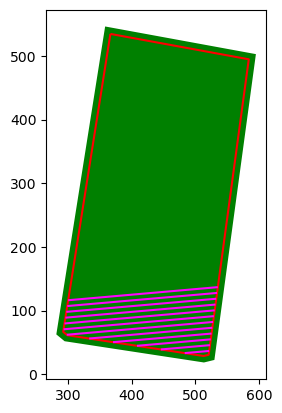

In [13]:
d = 10
theta_z = 5  # Rotation angle in degrees around z-axis
dx = d/(np.sin(np.radians(theta_z))+0.01)
# dx = d
vector = np.array([10000, 0])
rotated_vector = rotate_vector_z(vector, theta_z)
rotated_vector = [[0,0],list(rotated_vector)]
vector_list = []
if theta_z == 0:
    for i in range(-10,10):
        vector_list.append([[rotated_vector[0][0],rotated_vector[0][1]+i*d],[rotated_vector[1][0],rotated_vector[1][1]+i*d]])
else:
    for i in range(-10,10):
        vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])



swaths = []
swaths_clipped = []
for i in range(len(vector_list)):
    swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length 
        #for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax,color = 'magenta')
        total_swath_length+=swaths_clipped[i][0].length
print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))

plt.show()

1878.6717201392585

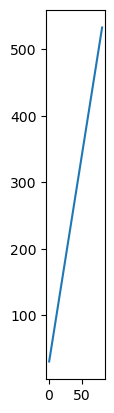

In [15]:
def linefromvec(vec):
    slope = (vec[1][1]-vec[0][1])/(vec[1][0]-vec[0][0])
    intercept = vec[1][1]-vec[1][0]*slope
    return slope,intercept

vector = np.array([[308.976881,	75.054454],[379.051873,	517.120079]])
slope,intercept = linefromvec(vector)
# xmin = min(field1_with_headlands.get_coordinates()['x'])
# xmax = max(field1_with_headlands.get_coordinates()['x'])
# ymin = slope*xmin+intercept
# ymax = slope*xmax+intercept

ymin = min(field_with_headlands.get_coordinates()['y'])
ymax = max(field_with_headlands.get_coordinates()['y'])
xmin = ymin/slope-intercept
xmax = ymax/slope-intercept

# plt.plot(vector[0],vector[1])
vector = np.array([[xmin-xmin,ymin],[xmax-xmin,ymax]])

line = gpd.GeoSeries(LineString(vector))
fig, ax = plt.subplots()
line.plot(ax = ax)

xmin

Theta: 0.000000, total_length: 1757.256119


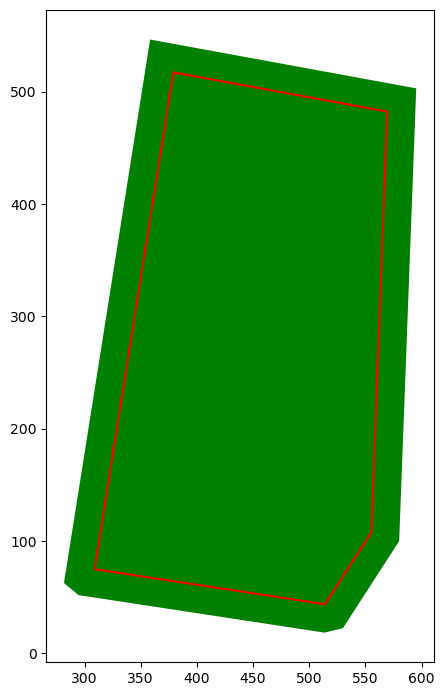

array([[379.05187336, 517.12007865],
       [567.19682974, 482.6150516 ]])

In [236]:
field1 = gpd.GeoSeries(Polygon(coordinates[0][0]))
field1_with_headlands = field1.buffer(-25)
fig, ax = plt.subplots(figsize = [5,10])
field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')


d = 10
theta_z = 00  # Rotation angle in degrees around z-axis
dx = d/(np.sin(np.radians(theta_z))+0.01)
dx = 10
# dx = d
# vector = np.array([[xmin,ymin],[xmax,ymax]])
# rotated_vector = rotate_vector_z(vector, theta_z)
# rotated_vector = [[0,0],list(rotated_vector)]
vector_list = []
if theta_z == 0:
    for i in range(-100,100):
        vector_list.append([[vector[0][0]+i*d,vector[0][1]],[vector[1][0]+i*d,vector[1][1]]])
else:
    for i in range(-100,100):
        vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])

swaths = []
swaths_clipped = []
for i in range(len(vector_list)):
    swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field1_with_headlands))

total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length 
        #for vectors that are completely outside of the boundaries
        # swaths_clipped[i].plot(ax = ax,color = 'magenta')
        # swaths[i].plot
        total_swath_length+=swaths_clipped[i][0].length
print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))

fig.savefig('./data/images/field_with_headlangs.svg', format='svg')
plt.show()

# swaths_clipped[15].get_coordinates()
vector

In [237]:

swaths_clipped_nonempty = [swath for swath in swaths_clipped if not swath.get_coordinates().empty]
list_coords = []
for i in range(len(swaths_clipped_nonempty)):
    list_coords.append(swaths_clipped_nonempty[0].get_coordinates())


In [19]:
field1_with_headlands.get_coordinates()

,x,y
0,308.976881,75.054454
0,379.051873,517.120079
0,567.196830,482.615052
0,507.750939,44.733758
0,308.976881,75.054454


In [20]:
np.array([379.051873,	517.120079])-np.array([308.976881,	75.054454])
# swaths_clipped_nonempty

array([ 70.074992, 442.065625])

In [21]:
from dubins_curves import *

line1 = swaths_clipped_nonempty[0]
line2 = swaths_clipped_nonempty[1]
line1_coords = line1.get_coordinates()
line2_coords = line2.get_coordinates()
point1 = line1_coords.iloc[1]
point2 = line2_coords.iloc[1]



diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
slope1 = diff1['y']/diff1['x']
heading_1 = math.degrees(math.atan(slope1))

diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
slope2 = diff2['y']/diff1['x']
heading_2 = math.degrees(math.atan(slope2))+180

pt1 = (line1_coords.iloc[1]['x'],line1_coords.iloc[1]['y'],90-heading_1)
pt2 = (line2_coords.iloc[1]['x'],line2_coords.iloc[1]['y'],90-heading_2)
turning_rad = 5

path = dubins_main(pt1,pt2,turning_rad)




In [22]:
# LineString(path)
curve1 = LineString(path[:,0:2])

<Axes: >

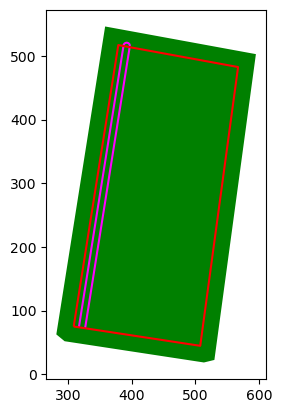

In [23]:
# MultiLineString((line1,curve1,line2))
line = gpd.GeoSeries((line1[0],curve1,line2[0]))
fig, ax = plt.subplots()
line.plot(ax = ax, color = 'magenta')
field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')
# line1[0]

In [24]:

turning_rad = 10
line = []

for i in range(len(swaths_clipped_nonempty)-1):
    line1 = swaths_clipped_nonempty[i]
    line2 = swaths_clipped_nonempty[i+1]
    line1_coords = line1.get_coordinates()
    line2_coords = line2.get_coordinates()

    if i%2 != 0:
        point1 = line1_coords.iloc[0]
        point2 = line2_coords.iloc[0]
        diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
        slope1 = diff1['y']/diff1['x']
        heading_1 = math.degrees(math.atan(slope1))+180

        diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
        slope2 = diff2['y']/diff1['x']
        heading_2 = math.degrees(math.atan(slope2))
        pt1 = (line1_coords.iloc[0]['x'],line1_coords.iloc[0]['y'],90-heading_1)
        pt2 = (line2_coords.iloc[0]['x'],line2_coords.iloc[0]['y'],90-heading_2)
    else:
        point1 = line1_coords.iloc[1]
        point2 = line2_coords.iloc[1]
        diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
        slope1 = diff1['y']/diff1['x']
        heading_1 = math.degrees(math.atan(slope1))

        diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
        slope2 = diff2['y']/diff1['x']
        heading_2 = math.degrees(math.atan(slope2))+180
        pt1 = (line1_coords.iloc[1]['x'],line1_coords.iloc[1]['y'],90-heading_1)
        pt2 = (line2_coords.iloc[1]['x'],line2_coords.iloc[1]['y'],90-heading_2)



    path = dubins_main(pt1,pt2,turning_rad)
    curve1 = LineString(path[:,0:2])
    line.append(gpd.GeoSeries((line1[0],curve1,line2[0])))
        


hoi
x    387.179747
y    515.629459
Name: 0, dtype: float64
hoi
x    406.614744
y    512.065159
Name: 0, dtype: float64
hoi
x    426.049741
y    508.500859
Name: 0, dtype: float64
hoi
x    445.484739
y    504.936559
Name: 0, dtype: float64
hoi
x    464.919736
y    501.372259
Name: 0, dtype: float64
hoi
x    484.354733
y    497.807958
Name: 0, dtype: float64
hoi
x    503.789730
y    494.243658
Name: 0, dtype: float64
hoi
x    523.224727
y    490.679358
Name: 0, dtype: float64
hoi
x    542.659725
y    487.115058
Name: 0, dtype: float64
hoi
x    562.094722
y    483.550758
Name: 0, dtype: float64


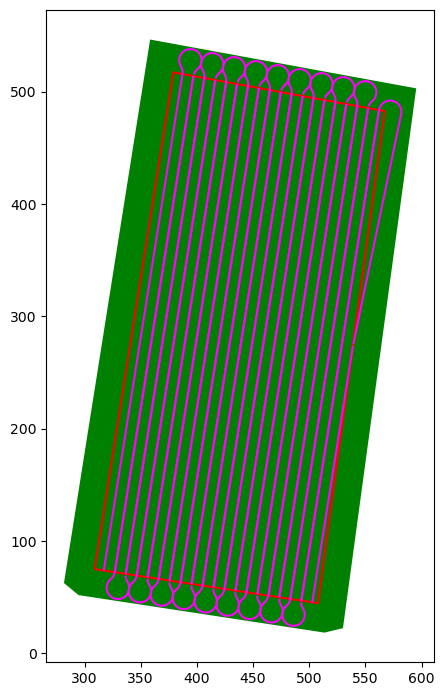

In [25]:

fig, ax = plt.subplots(figsize = [5,10])

field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')
for i in range(len(line)):
    line[i].plot(ax = ax, color = 'magenta')

fig.savefig('./data/images/field_generated_swaths.svg', format='svg')


In [26]:
line1_coords.iloc[1]


x    562.094722
y    483.550758
Name: 0, dtype: float64

In [33]:
import pandas as pd

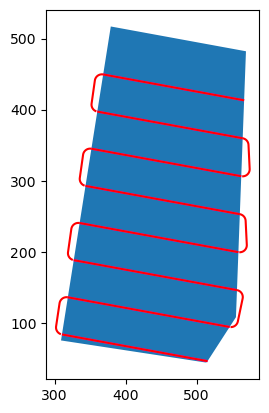

In [239]:
def linefromvec(vec):
    """
    turn a vector in to a line in 2d with a slope and intercept

    attrs:
        vec (array): 2x2 array with x,y coords of begin point in first row, xy coords of end point in second row

    returns:
        slope (float): slope of the resulting line
        intercept (float): intercept of the resulting line

    """
    slope = (vec[1][1]-vec[0][1])/(vec[1][0]-vec[0][0])
    intercept = vec[1][1]-vec[1][0]*slope
    return slope,intercept

def edge_to_line(coordinates):
    """
    turns a df of field coordinates into a df with the slopes and intercepts of all edges of the field
    
    attrs:
        coordinates (geopandas DataFrame): a GeoPandas Dataframe containing the xy coordinates of all points that describe a polygon. Can be obtained using the get_coordinates() method
    returns:
        edge_lines (pandas DataFrame): a Pandas DF that contains slopes and intercepts of all lines describing the outline of a polygon
    
    """
    edge_points = len(coordinates)
    slopes = []
    intercepts = []
    for edge in range(edge_points-1):
        x_begin = coordinates.iloc[edge]['x']
        x_end = coordinates.iloc[edge+1]['x']
        y_begin = coordinates.iloc[edge]['y']
        y_end = coordinates.iloc[edge+1]['y']
        vector = np.array([[x_begin,y_begin],[x_end,y_end]])
        slope,intercept = linefromvec(vector)
        slopes.append(slope)
        intercepts.append(intercept)
    d = {'slope': slopes, 'intercept': intercepts}
    edge_lines = pd.DataFrame(data = d)
    return edge_lines
             
def basis_AB_line(edge,coordinates):  ## TODO: make the initial position align with the actual chosen edge, right now its just randomly placed somewhere
    """
    Creates an AB line to be used as basis for filling the field, the AB line has the same orientation as the given edge  
        and the length of the AB line is such that it covers the entire y-range of the field

    attrs:
        edge (Pandas Series): a slice of a dataframe containing the edge information, with the slope and intercept information of the 
                                edge for which you want to create a base AB line
        coordinates (pandas DataFrame): a pandas DF containing all the coordinates that describe the polygon

    returns:   
        base_AB (numpy array): a line object that covers the entire y-range of the polygon with a direction
                                        specified in the edge attribute
    """
    slope = edge['slope']
    intercept = edge['intercept']
    ymin = min(coordinates['y'])
    ymax = max(coordinates['y'])
    xmin = ymin/slope-intercept
    xmax = ymax/slope-intercept
    if slope >= 0:
        vector = np.array([[xmin-xmin ,ymin],[xmax-xmin,ymax]])
    else:
        vector = np.array([[xmin-xmax ,ymin],[xmax-xmax,ymax]])
    # line = gpd.GeoSeries(LineString(vector))
    base_AB = vector
    return base_AB,slope

def fill_field_AB(base_AB,slope,coordinates,d):
    """
    takes the base AB line, its slope and a distance between lines and fills the field with AB lines of a given angle
    attrs:
        base_AB (array): array with xy coordinates of beginning and end points of the base vector
        slope (float): the slope of the basis AB line
        coordinates (pandas DataFrame): a pandas DF containing all the coordinates that describe the polygon
        d (float): distance between two AB lines

    returns:
        swath_list (list): a list containing Geoseries objects of different AB-lines
    """
    # Calculate angle of AB line wrt x-axis
    theta = np.arctan(slope)
    # using the angle and parameter d to calculate x-offset between swaths
    dx = d/(np.sin(theta)+0.01)

    # Determine amount of AB-lines that are needed
    xmax = max(coordinates['x'])
    xmin = min(coordinates['x'])
    nr_passes = int((xmax-xmin)//d + 2)*2

    # Initialize empty lists that will contain vectors and geoseries objects
    vector_list = []
    swath_list = []
    for swath in range(nr_passes):
        vector_list.append([[base_AB[0][0]+dx*swath,base_AB[0][1]],[base_AB[1][0]+dx*swath,base_AB[1][1]]])
        swath_list.append(gpd.GeoSeries(LineString(vector_list[swath])))
        # pass

    return swath_list

def clip_swaths(swath_list,field):
    """
    function to clip swaths to the headlands
    attrs:
        swath_list (list): List of geoseries objects that describe the generated swaths
        field (geopandas Geoseries): Geoseries object that describes the field geometry

    returns:
        swaths_clipped_nonempty (list): a list of geoseries objects that contains the clipped swaths that are not empty
    """
    swaths_clipped = []
    for swath in range(len(swath_list)):
        swaths_clipped.append(gpd.clip(swath_list[swath],field))
        swaths_clipped_nonempty = [swath for swath in swaths_clipped if not swath.get_coordinates().empty]
    return swaths_clipped_nonempty


def generate_path(swaths_clipped_nonempty,turning_rad,offset):
    turning_rad = 10
    line = []

    for i in range(len(swaths_clipped_nonempty)-1):
        line1 = swaths_clipped_nonempty[i]
        line2 = swaths_clipped_nonempty[i+1]
        line1_coords = line1.get_coordinates()
        line2_coords = line2.get_coordinates()

        if i%2 != 0:
            point1 = line1_coords.iloc[0]
            point2 = line2_coords.iloc[0]
            diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
            slope1 = diff1['y']/diff1['x']
            heading_1 = math.degrees(math.atan(slope1))+180

            diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
            slope2 = diff2['y']/diff1['x']
            heading_2 = math.degrees(math.atan(slope2))
            pt1 = (line1_coords.iloc[0]['x'],line1_coords.iloc[0]['y'],90-heading_1+offset)
            pt2 = (line2_coords.iloc[0]['x'],line2_coords.iloc[0]['y'],90-heading_2+offset)
        else:
            point1 = line1_coords.iloc[1]
            point2 = line2_coords.iloc[1]
            diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
            slope1 = diff1['y']/diff1['x']
            heading_1 = math.degrees(math.atan(slope1))

            diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
            slope2 = diff2['y']/diff1['x']
            heading_2 = math.degrees(math.atan(slope2))+180
            pt1 = (line1_coords.iloc[1]['x'],line1_coords.iloc[1]['y'],90-heading_1+offset)
            pt2 = (line2_coords.iloc[1]['x'],line2_coords.iloc[1]['y'],90-heading_2+offset)



        path = dubins_main(pt1,pt2,turning_rad)
        curve1 = LineString(path[:,0:2])
        line.append(gpd.GeoSeries((line1[0])))
        line.append(gpd.GeoSeries(curve1))
    line.append(gpd.GeoSeries(line2[0]))
    return line
        


coordinates = field1_with_headlands.get_coordinates()
b = edge_to_line(coordinates)
line,slope = basis_AB_line(b.iloc[1],coordinates)
swath_list = fill_field_AB(line,slope,coordinates,50)
swaths_clipped = clip_swaths(swath_list,field1_with_headlands)
if slope> 0:
    offset = 0
else:
    offset = 180
    
path = generate_path(swaths_clipped,10,offset)

fig, ax = plt.subplots()
field1_with_headlands.plot(ax = ax)
for i in range(len(swaths_clipped)):
    swaths_clipped[i].plot(ax = ax, color = 'magenta')

for i in range(len(path)):
    path[i].plot(ax = ax,color = 'r')
# swaths



In [204]:
type(field)

geopandas.geoseries.GeoSeries

IndexError: single positional indexer is out-of-bounds

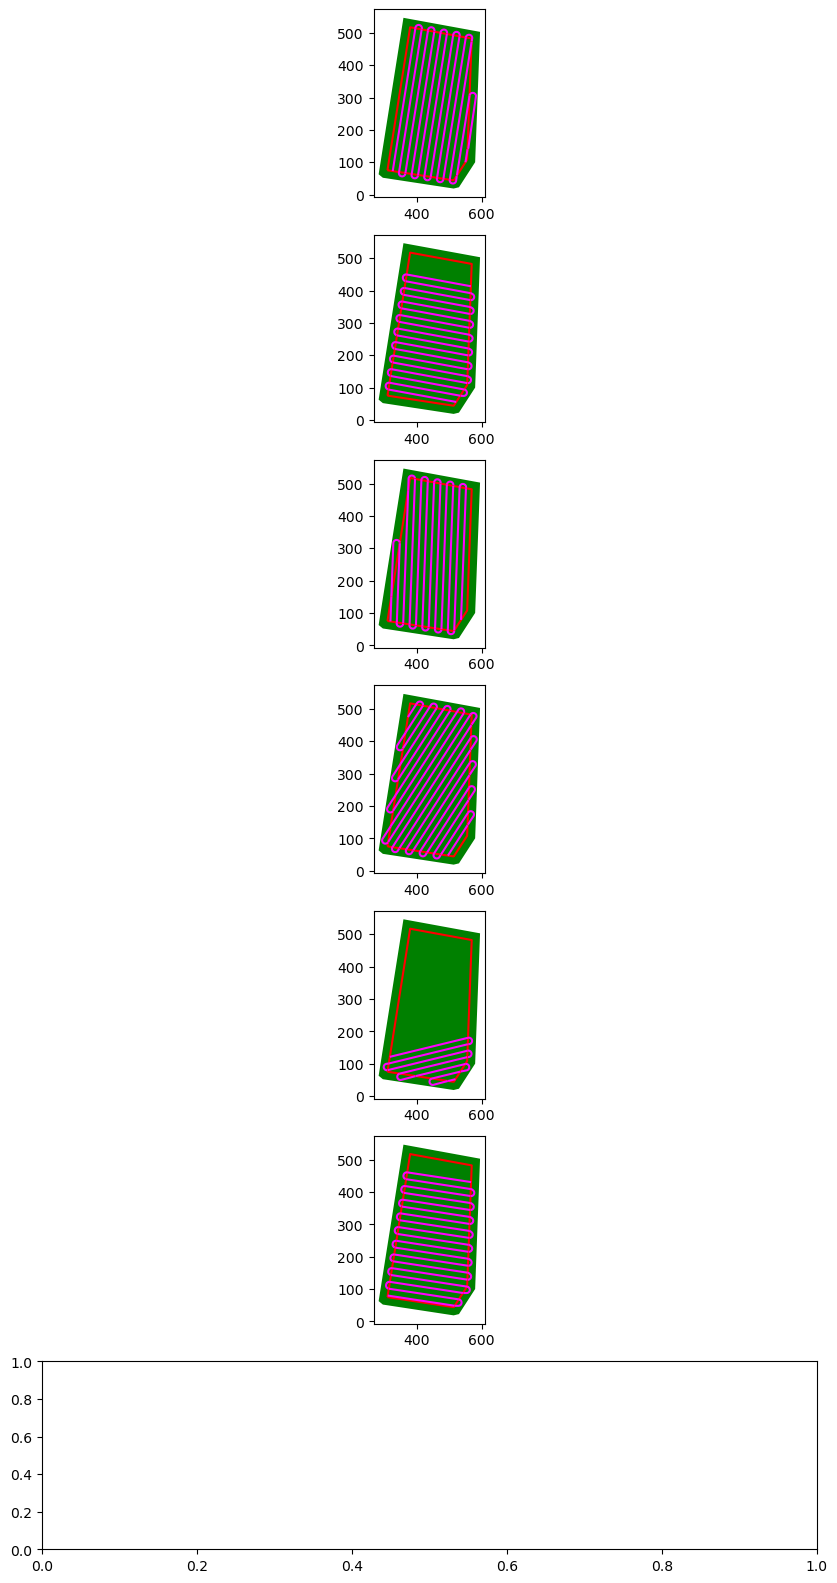

In [242]:
fig, ax = plt.subplots(4,1,figsize = (10,20))
coordinates = field1_with_headlands.get_coordinates()
lines = edge_to_line(coordinates)
turning_rad = 10
for i in range(len(coordinates)):
    line,slope = basis_AB_line(lines.iloc[i],coordinates)
    swath_list = fill_field_AB(line,slope,coordinates,20)
    swaths_clipped = clip_swaths(swath_list,field1_with_headlands)
    
    if slope > 0:
        offset = 0
    else:
        offset = 180
    path = generate_path(swaths_clipped,turning_rad,offset)

    field1.plot(ax = ax[i],color = 'g')
    field1_with_headlands.boundary.plot(ax = ax[i],color = 'r')
    for ii in range(len(path)):
        path[ii].plot(ax = ax[i], color = 'magenta');